In [ ]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import datetime

In [116]:
charging = pd.read_csv("../charging_sessions.csv", encoding = "ISO-8859-1")

In [117]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])

charging['connectionTime'] = charging['connectionTime'].dt.tz_localize(None)
charging['disconnectTime'] = charging['disconnectTime'].dt.tz_localize(None)

site_a = charging[charging["siteID"] == 1]
site_b = charging[charging["siteID"] == 2]



In [137]:
unique_spaces_a = site_a["stationID"].nunique()
unique_spaces_b = site_b["stationID"].nunique()

print(unique_spaces_a)
print(unique_spaces_b)

52
55


In [118]:
def create_utilization(df) -> pd.DataFrame:
    result = []

    # Combine connect and disconnect dates and get unique days
    unique_days = pd.date_range(start=df['connectionTime'].min().date(), end=df['disconnectTime'].max().date())

    # Iterate through each unique day
    for day in unique_days:
        # Generate hourly time slots for the day
        time_slots = pd.date_range(start=day, periods=24, freq='H')
        for time in time_slots:
            # Count the number of cars parked during this hour
            utilization = np.sum((df['connectionTime'] <= time) & (df['disconnectTime'] > time))
            result.append({'time': time.hour, 'utilization': utilization})

    # Convert the result list to a dataframe
    return pd.DataFrame(result)

utilization_a = create_utilization(site_a)
utilization_b = create_utilization(site_b)



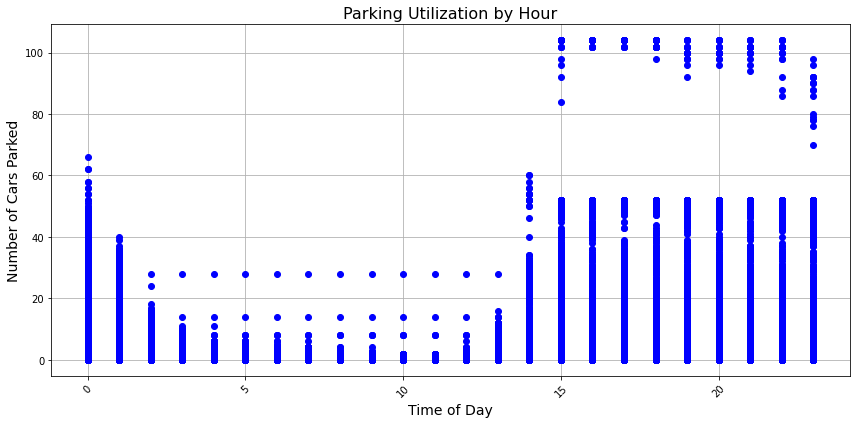

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(utilization_a['time'], utilization_a['utilization'], marker='o', linestyle='', color='b')

# Formatting the plot
plt.title('Parking Utilization by Hour', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [142]:

def check_overlap(df):
    overlapping_rows = []

    # Iterate through each row
    for i, row in df.iterrows():
        # Get the current row's spaceID, stationID, and time window (connection and disconnect times)
        spaceID = row['spaceID']
        stationID = row['stationID']
        connection_time = row['connectionTime']
        disconnect_time = row['disconnectTime']
    
        # Find overlapping rows with the same spaceID and stationID within the time window
        overlapping = df[(df['spaceID'] == spaceID) &  # Filter by spaceID
                     (df['stationID'] == stationID) &  # Filter by stationID
                     (df['connectionTime'] < disconnect_time) &  # Check if the connectionTime is before the current row's disconnectTime
                     (df['disconnectTime'] > connection_time)]  # Check if the disconnectTime is after the current row's connectionTime
        
        # Exclude the current row from being considered in its own overlap check
        overlapping = overlapping[overlapping.index != i]
        
        # If there are overlapping rows, append them to the result list
        if not overlapping.empty:
            overlapping_rows.append((i, overlapping))
        print(i)
    
    return overlapping_rows

# Assuming 'df' is your DataFrame with the relevant columns
overlaps = check_overlap(site_a)

# Example of printing the overlapping rows:
for idx, overlap in overlaps:
    print(f"Row {idx} has overlaps with the following rows:")
    print(overlap[['spaceID', 'stationID', 'connectionTime', 'disconnectTime']])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

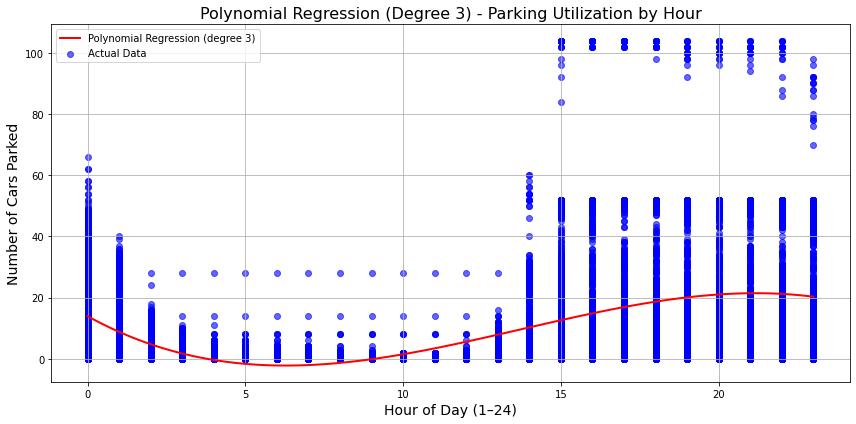

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


x_a = utilization_a["time"].values.reshape(-1, 1)
y_a = utilization_a["utilization"]

# Transform the feature to include polynomial terms (e.g., quadratic, cubic, etc.)
poly_degree = 3  # Degree of the polynomial (can be adjusted)
poly = PolynomialFeatures(degree=poly_degree)
x_a_poly = poly.fit_transform(x_a)  # Transform the data to include polynomial features

x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a_poly, y_a, test_size=0.3, random_state=42)

# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(x_a_train, y_a_train)

# Make predictions
y_a_pred = model.predict(x_a_test)

mse = mean_squared_error(y_a_test, y_a_pred)

plt.figure(figsize=(12, 6))
plt.scatter(x_a, y_a, color='blue', label='Actual Data', alpha=0.6)  # Plot the actual data

# Plot the Polynomial Regression predictions
X_grid = np.linspace(min(x_a), max(x_a), 100).reshape(-1, 1)  # Create a smooth grid for the x-axis
y_grid = model.predict(poly.transform(X_grid))  # Predict using the polynomial features

plt.plot(X_grid, y_grid, color='red', label=f'Polynomial Regression (degree {poly_degree})', linewidth=2)  # Plot the polynomial predictions

plt.title(f'Polynomial Regression (Degree {poly_degree}) - Parking Utilization by Hour', fontsize=16)
plt.xlabel('Hour of Day (1–24)', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

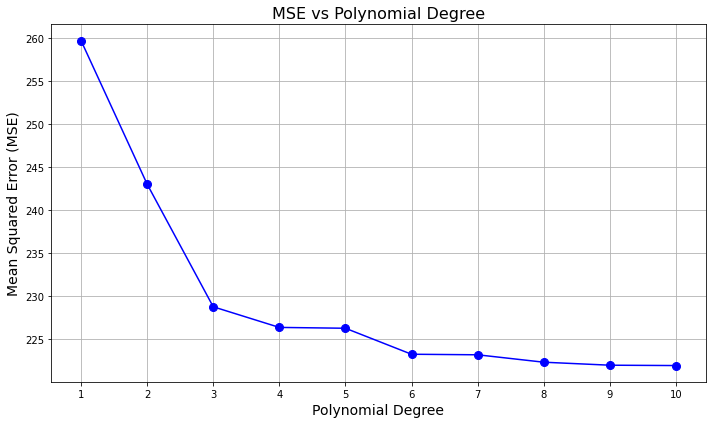

In [135]:
mse_values = []

# Loop through polynomial degrees from 1 to 10
for poly_degree in range(1, 11):
    # Transform the feature to include polynomial terms
    poly = PolynomialFeatures(degree=poly_degree)
    x_a_poly = poly.fit_transform(x_a)  # Transform the data to include polynomial features

    # Split the data into training and testing sets
    x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a_poly, y_a, test_size=0.5, random_state=42)

    # Create and fit the Linear Regression model
    model = LinearRegression()
    model.fit(x_a_train, y_a_train)

    # Make predictions
    y_a_pred = model.predict(x_a_test)

    # Calculate the MSE for this degree
    mse = mean_squared_error(y_a_test, y_a_pred)
    mse_values.append(mse)

# Plot MSE values for each degree of polynomial
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mse_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('MSE vs Polynomial Degree', fontsize=16)
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  # To ensure all degrees are labeled on the x-axis
plt.tight_layout()
plt.show()